In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform, randint

In [2]:
data = pd.read_csv("C:/Users/Akif/Desktop/football/rankingv5v2.csv")

features = [
    'home_team_points', 'away_team_points', 'home_attack_value',
    'away_attack_value', 'home_midfield_value', 'away_midfield_value',
    'home_defender_value', 'away_defender_value', 'home_goalkeeper_value',
    'away_goalkeeper_value', 'home_total_market_value', 'away_total_market_value',
    'home_power_score', 'away_power_score'
]

X = data[features]
y = data['result']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

param_distributions = {
    'model__C': uniform(0.01, 100),  # Logistic Regression
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__solver': ['lbfgs', 'liblinear', 'saga'],
    'model__max_iter': randint(100, 1000),
}

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,  # Number of different combinations to try
    scoring='accuracy',
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=2
)

In [6]:
random_search.fit(X_train_smote, y_train_smote)

best_model = random_search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_smote, y_train_smote, cv=cv)
print(f"Cross-validated Accuracy: {np.mean(cv_scores):.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Akif\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Akif\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Akif\anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Akif\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=s

Cross-validated Accuracy: 0.4747


In [7]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.5011


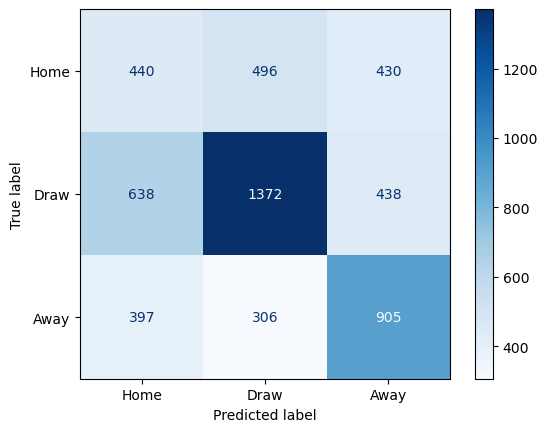

In [8]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Home', 'Draw', 'Away'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the output for multiclass roc_auc_score
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 0=Home, 1=Draw, 2=Away
y_pred_prob = best_model.predict_proba(X_test)

# Calculate the ROC AUC score with 'ovr' (One-vs-Rest)
roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr')

print(f'Multiclass ROC AUC Score: {roc_auc:.4f}')

Multiclass ROC AUC Score: 0.6700


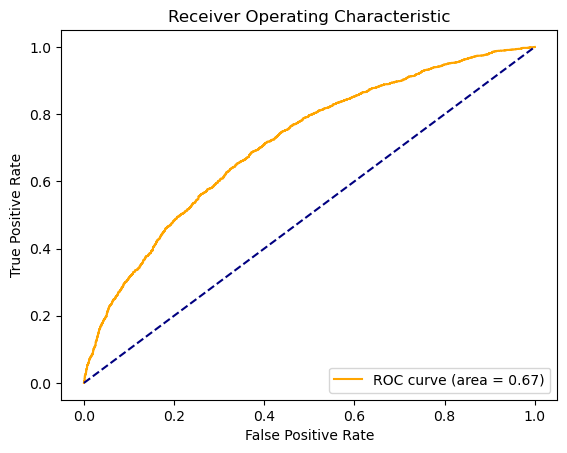

In [11]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
def predict_match(home_team_id, away_team_id, data, model):
    match_data = data[
        (data['home_club_id'] == home_team_id) & 
        (data['away_club_id'] == away_team_id)
    ].iloc[0]

    input_data = pd.DataFrame({
        'home_team_points': [match_data['home_team_points']],
        'away_team_points': [match_data['away_team_points']],
        'home_attack_value': [match_data['home_attack_value']],
        'away_attack_value': [match_data['away_attack_value']],
        'home_midfield_value': [match_data['home_midfield_value']],
        'away_midfield_value': [match_data['away_midfield_value']],
        'home_defender_value': [match_data['home_defender_value']],
        'away_defender_value': [match_data['away_defender_value']],
        'home_goalkeeper_value': [match_data['home_goalkeeper_value']],
        'away_goalkeeper_value': [match_data['away_goalkeeper_value']],
        'home_total_market_value': [match_data['home_total_market_value']],
        'away_total_market_value': [match_data['away_total_market_value']],
        'home_power_score': [match_data['home_power_score']],
        'away_power_score': [match_data['away_power_score']],
    })

    # No need to scale manually; pass the data directly to the model pipeline
    prediction_proba = model.predict_proba(input_data)

    home_win_proba = prediction_proba[0][1]
    draw_proba = prediction_proba[0][0]
    away_win_proba = prediction_proba[0][2]

    print(f"Prediction Probabilities:\nHome Win: {home_win_proba:.2f}\nDraw: {draw_proba:.2f}\nAway Win: {away_win_proba:.2f}")

    if home_win_proba > draw_proba and home_win_proba > away_win_proba:
        print("Predicted Outcome: Home Win")
    elif away_win_proba > draw_proba and away_win_proba > home_win_proba:
        print("Predicted Outcome: Away Win")
    else:
        print("Predicted Outcome: Draw")

In [15]:
scaler = best_model.named_steps['scaler']

In [19]:
input_data_scaled = scaler.transform(X)

In [21]:
home_team_id = 1421
away_team_id = 583

predict_match(home_team_id, away_team_id, data, best_model);

Prediction Probabilities:
Home Win: 0.09
Draw: 0.33
Away Win: 0.59
Predicted Outcome: Away Win
